<a href="https://colab.research.google.com/github/NzimbaEnvoy/Self-Driving-Rover/blob/main/Rover_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow albumentations opencv-python scikit-learn tqdm ultralytics matplotlib


# Downloading dataset from Roboflow

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="BGxK76n7MZnM4u7Fgw2H")  # Your API key
project = rf.workspace("unibo-i7a4x").project("mars2-hmiyo")
version = project.version(4)
dataset = version.download("yolov8")

print("✅ Dataset downloaded to:", dataset.location)
!ls {dataset.location}


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Mars2-4 in yolov8:: 100%|██████████| 2058/2058 [00:00<00:00, 3837.88it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Dataset downloaded to: /content/Mars2-4
data.yaml  README.dataset.txt  README.roboflow.txt  train


# *Locating* labels folder and check class distribution

In [ ]:
import os
from collections import Counter

# Find labels folder (works for split or unsplit datasets)
labels_root = None
for root, dirs, files in os.walk(dataset.location):
    if os.path.basename(root) == "labels":
        labels_root = root
        break

if labels_root is None:
    raise FileNotFoundError("❌ Could not find labels folder in dataset.")

print("📂 Labels folder found at:", labels_root)

# Count classes from YOLO label files
def get_class_counts_nested(labels_root):
    counts = Counter()
    for root, _, files in os.walk(labels_root):
        for label_file in files:
            if label_file.endswith(".txt"):
                with open(os.path.join(root, label_file), "r") as f:
                    for line in f:
                        cls_id = int(float(line.split()[0]))  # FIX: handles "2.0"
                        counts[cls_id] += 1
    return counts

class_counts = get_class_counts_nested(labels_root)
print("📊 Class counts before balancing:", class_counts)


📂 Labels folder found at: /content/Mars2-4/train/labels
📊 Class counts before balancing: Counter({3: 1551, 0: 651, 2: 282, 1: 258})


# Visualising Before Balancing

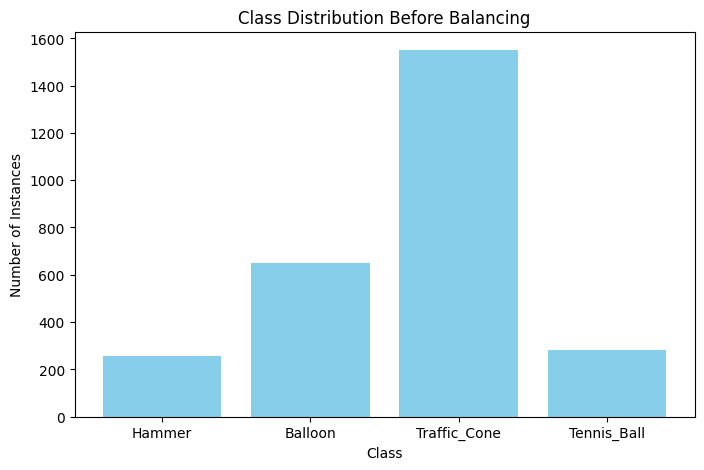

In [ ]:
import matplotlib.pyplot as plt

labels_map = {0: "Balloon", 1: "Hammer", 2: "Tennis_Ball", 3: "Traffic_Cone"}

plt.figure(figsize=(8, 5))
plt.bar([labels_map[c] for c in class_counts.keys()], class_counts.values(), color='skyblue')
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.show()


# Setup augmentation pipeline

In [ ]:
import albumentations as A
import cv2
import numpy as np
import random
import shutil
from tqdm import tqdm

# Augmentation transformations
augmentor = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


# Locating images folder and balance dataset

In [ ]:
# Find images folder (works for split or unsplit datasets)
images_root = None
for root, dirs, files in os.walk(dataset.location):
    if os.path.basename(root) == "images":
        images_root = root
        break

if images_root is None:
    raise FileNotFoundError("❌ Could not find images folder in dataset.")

print("📂 Images folder found at:", images_root)

# Find the largest class count
max_count = max(class_counts.values())

# Oversample with augmentation
def oversample_with_augmentation(cls_id, count):
    needed = max_count - count
    if needed <= 0:
        return

    # Get all images for this class
    class_images = []
    for root, _, files in os.walk(labels_root):
        for label_file in files:
            if label_file.endswith(".txt"):
                with open(os.path.join(root, label_file), "r") as f:
                    if any(int(float(line.split()[0])) == cls_id for line in f):  # FIX
                        img_name = label_file.replace(".txt", ".jpg")
                        img_path = os.path.join(images_root, img_name)
                        if os.path.exists(img_path):
                            class_images.append((img_path, os.path.join(root, label_file)))

    for i in tqdm(range(needed), desc=f"Augmenting class {cls_id}"):
        img_path, label_path = random.choice(class_images)

        img = cv2.imread(img_path)
        with open(label_path, "r") as f:
            labels = f.readlines()

        bboxes = []
        class_labels = []
        for line in labels:
            parts = line.strip().split()
            if int(float(parts[0])) == cls_id:  # FIX
                bboxes.append(list(map(float, parts[1:])))
                class_labels.append(int(float(parts[0])))

        if not bboxes:
            continue

        augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        new_img_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug{i}.jpg"
        new_label_name = new_img_name.replace(".jpg", ".txt")

        cv2.imwrite(os.path.join(images_root, new_img_name), aug_img)
        with open(os.path.join(labels_root, new_label_name), "w") as f:
            for label, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{label} {' '.join(map(str, bbox))}\n")

# Apply augmentation to all underrepresented classes
for cls_id, count in class_counts.items():
    oversample_with_augmentation(cls_id, count)

print("✅ Balancing complete!")


📂 Images folder found at: /content/Mars2-4/train/images


Augmenting class 2: 100%|██████████| 1269/1269 [00:08<00:00, 141.69it/s]

✅ Balancing complete!


# Visualise After Balancing

📊 Class counts after balancing: Counter({0: 3149, 2: 2265, 1: 1720, 3: 1551})


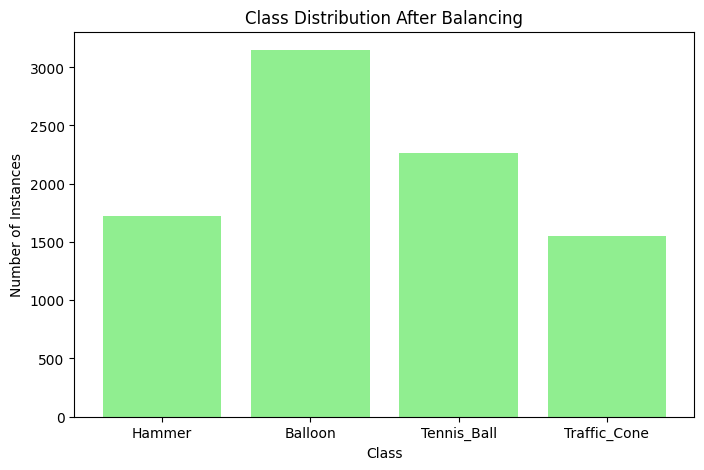

In [ ]:
class_counts_after = get_class_counts_nested(labels_root)
print("📊 Class counts after balancing:", class_counts_after)

plt.figure(figsize=(8, 5))
plt.bar([labels_map[c] for c in class_counts_after.keys()], class_counts_after.values(), color='lightgreen')
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.show()


# Splitting into train / val / test

In [ ]:
from sklearn.model_selection import train_test_split

# Get all images after balancing
all_images = [f for f in os.listdir(images_root) if f.endswith(".jpg")]

# Split: 70% train / 15% val / 15% test
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.30, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=42)

# Create split folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_root, split), exist_ok=True)
    os.makedirs(os.path.join(labels_root, split), exist_ok=True)

def move_files(img_list, split):
    for img in img_list:
        label = img.replace(".jpg", ".txt")
        shutil.move(os.path.join(images_root, img), os.path.join(images_root, split, img))
        shutil.move(os.path.join(labels_root, label), os.path.join(labels_root, split, label))

move_files(train_imgs, "train")
move_files(val_imgs, "val")
move_files(test_imgs, "test")

print("✅ Dataset split: 70% train, 15% val, 15% test")


✅ Dataset split: 70% train, 15% val, 15% test


# Updating YOLO data.yaml

In [ ]:
yaml_path = os.path.join(dataset.location, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(f"""
train: {images_root}/train
val: {images_root}/val
test: {images_root}/test

nc: 4
names: ["Balloon", "Hammer", "Tennis_Ball", "Traffic_Cone"]
""")

print("✅ data.yaml updated")


✅ data.yaml updated


# Training the Model_YOLOv8

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Change to yolov8s.pt for higher accuracy
model.train(
    data=os.path.join(dataset.location, "data.yaml"),
    epochs=100,
    imgsz=640,
    batch=8,
    patience=15
)


Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Mars2-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.1 ms, read: 821.0±353.1 MB/s, size: 53.4 KB)


train: Scanning /content/Mars2-4/train/labels/train... 3141 images, 19 backgrounds, 0 corrupt: 100%|██████████| 3141/3141 [00:01<00:00, 1944.58it/s]


train: New cache created: /content/Mars2-4/train/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 361.4±271.6 MB/s, size: 64.1 KB)


val: Scanning /content/Mars2-4/train/labels/val... 673 images, 5 backgrounds, 0 corrupt: 100%|██████████| 673/673 [00:00<00:00, 800.83it/s]

val: New cache created: /content/Mars2-4/train/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.13G      1.144      2.123      1.504         17        640: 100%|██████████| 393/393 [01:08<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:07<00:00,  5.56it/s]


                   all        673       1348      0.588      0.608      0.619      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.38G      1.158       1.64      1.512         26        640: 100%|██████████| 393/393 [01:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.01it/s]


                   all        673       1348      0.612      0.561      0.585      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.39G      1.149      1.488      1.504          7        640: 100%|██████████| 393/393 [01:04<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.86it/s]


                   all        673       1348      0.657      0.658      0.698      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.41G       1.12      1.343       1.48         10        640: 100%|██████████| 393/393 [01:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.10it/s]


                   all        673       1348      0.636      0.689      0.689      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.43G       1.07      1.258       1.44         12        640: 100%|██████████| 393/393 [01:04<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.02it/s]

                   all        673       1348      0.767      0.714      0.747      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.45G      1.031      1.155      1.411         12        640: 100%|██████████| 393/393 [01:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.92it/s]

                   all        673       1348      0.683      0.707      0.716      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.47G      1.011      1.111      1.393         13        640: 100%|██████████| 393/393 [01:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.49it/s]

                   all        673       1348      0.814      0.763      0.794       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.48G     0.9859      1.067      1.377         19        640: 100%|██████████| 393/393 [01:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.15it/s]

                   all        673       1348      0.776      0.741      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       1.5G     0.9706      1.028      1.366         12        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.03it/s]


                   all        673       1348      0.809      0.775      0.809      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.52G     0.9277     0.9735       1.33         16        640: 100%|██████████| 393/393 [01:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.67it/s]


                   all        673       1348      0.823      0.788      0.842      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.52G     0.9269     0.9544      1.333         20        640: 100%|██████████| 393/393 [01:04<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.08it/s]

                   all        673       1348      0.788      0.787      0.827      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.55G     0.9042     0.9047      1.301         25        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.78it/s]

                   all        673       1348      0.855      0.801      0.851      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.57G     0.8964     0.8951      1.306         32        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.52it/s]

                   all        673       1348      0.807      0.798      0.832      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.59G     0.8777     0.8589      1.299         13        640: 100%|██████████| 393/393 [01:04<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.10it/s]

                   all        673       1348      0.855      0.826      0.874      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       1.6G     0.8579     0.8402      1.275         13        640: 100%|██████████| 393/393 [01:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.39it/s]

                   all        673       1348      0.862       0.83      0.866      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.62G     0.8538     0.8227      1.267         23        640: 100%|██████████| 393/393 [01:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.93it/s]


                   all        673       1348      0.835      0.829      0.864      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.64G     0.8457     0.8039      1.266         18        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.38it/s]


                   all        673       1348       0.88      0.826      0.881      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.65G     0.8326     0.7984      1.252         12        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.77it/s]


                   all        673       1348      0.867       0.87      0.899      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.66G      0.828     0.7864      1.252         31        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.45it/s]


                   all        673       1348      0.896      0.849      0.889      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.69G     0.8211     0.7525      1.252         20        640: 100%|██████████| 393/393 [01:04<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.65it/s]

                   all        673       1348      0.882      0.852      0.896      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.71G     0.8033     0.7371      1.236         15        640: 100%|██████████| 393/393 [01:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.70it/s]

                   all        673       1348      0.872      0.866      0.896      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.72G     0.8099     0.7436      1.243         10        640: 100%|██████████| 393/393 [01:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.41it/s]


                   all        673       1348      0.893      0.848      0.889       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.74G     0.7964     0.7175       1.23         13        640: 100%|██████████| 393/393 [01:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.29it/s]


                   all        673       1348      0.898      0.872      0.904      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.75G     0.7823     0.7121      1.224         17        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.22it/s]


                   all        673       1348      0.908      0.861      0.904       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.77G     0.7752     0.6944      1.217         21        640: 100%|██████████| 393/393 [01:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.22it/s]

                   all        673       1348      0.902      0.847      0.891      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.79G     0.7677     0.6811      1.212         21        640: 100%|██████████| 393/393 [01:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.41it/s]


                   all        673       1348      0.888      0.868      0.901      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.79G     0.7621     0.6763      1.207         21        640: 100%|██████████| 393/393 [01:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.48it/s]

                   all        673       1348      0.914      0.863       0.91      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.82G     0.7632     0.6779      1.203         12        640: 100%|██████████| 393/393 [01:04<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.82it/s]


                   all        673       1348      0.925      0.863      0.914      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.84G     0.7531     0.6623      1.205         36        640: 100%|██████████| 393/393 [01:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.51it/s]


                   all        673       1348      0.908      0.854      0.903       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.86G     0.7404     0.6538      1.195         20        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.00it/s]


                   all        673       1348      0.896      0.881      0.919       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.87G     0.7409     0.6566      1.198         25        640: 100%|██████████| 393/393 [01:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.53it/s]


                   all        673       1348      0.924       0.86       0.91       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.89G     0.7303      0.651       1.19         18        640: 100%|██████████| 393/393 [01:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.75it/s]

                   all        673       1348      0.916      0.865      0.913      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.91G     0.7244     0.6383      1.176         16        640: 100%|██████████| 393/393 [01:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.52it/s]

                   all        673       1348      0.911      0.879      0.928      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.92G     0.7115     0.6265      1.178         19        640: 100%|██████████| 393/393 [01:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.68it/s]

                   all        673       1348      0.914      0.872      0.907      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.93G     0.7203     0.6133      1.183         16        640: 100%|██████████| 393/393 [01:04<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.15it/s]


                   all        673       1348      0.905      0.888      0.919      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.96G     0.7215     0.6121      1.183         18        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.59it/s]

                   all        673       1348      0.921      0.892      0.923      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.98G     0.7126     0.6083      1.176         17        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.96it/s]

                   all        673       1348      0.934      0.877      0.919      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.99G      0.708     0.5952      1.163         22        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.19it/s]


                   all        673       1348      0.924       0.87      0.925      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.01G     0.7046     0.5894       1.17         16        640: 100%|██████████| 393/393 [01:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.50it/s]

                   all        673       1348      0.948      0.881       0.93      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.03G     0.7014     0.5963      1.175         20        640: 100%|██████████| 393/393 [01:04<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.87it/s]

                   all        673       1348      0.914      0.887      0.926      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.04G     0.6911     0.5774      1.161         24        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.44it/s]

                   all        673       1348      0.919      0.886      0.929      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.06G     0.6913     0.5899      1.164         16        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.08it/s]


                   all        673       1348      0.916       0.89      0.926      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.07G     0.6757     0.5743      1.151         13        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.63it/s]


                   all        673       1348      0.924      0.881       0.92       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.1G     0.6787     0.5682      1.151         14        640: 100%|██████████| 393/393 [01:04<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.54it/s]

                   all        673       1348      0.923      0.906      0.927      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.12G     0.6763     0.5664      1.147         14        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.65it/s]

                   all        673       1348      0.932      0.886      0.926      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.13G     0.6705     0.5652      1.146         16        640: 100%|██████████| 393/393 [01:04<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.86it/s]

                   all        673       1348      0.949      0.891      0.933       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.15G     0.6698     0.5633      1.146         28        640: 100%|██████████| 393/393 [01:04<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.08it/s]

                   all        673       1348       0.93      0.894      0.932       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.16G     0.6578     0.5457      1.136         20        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.48it/s]

                   all        673       1348      0.925      0.897      0.928      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.18G     0.6615      0.552      1.137         19        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.44it/s]

                   all        673       1348      0.916      0.907      0.934      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.2G     0.6603     0.5525      1.141         12        640: 100%|██████████| 393/393 [01:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.30it/s]

                   all        673       1348      0.924      0.887      0.933      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.21G     0.6499     0.5467      1.135         23        640: 100%|██████████| 393/393 [01:04<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.46it/s]


                   all        673       1348      0.907      0.915      0.937      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.23G     0.6464     0.5255      1.133         16        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.06it/s]

                   all        673       1348      0.909      0.907      0.935      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.25G      0.643     0.5306      1.125         14        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.27it/s]

                   all        673       1348      0.913      0.909      0.937       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.27G     0.6294     0.5164      1.128         17        640: 100%|██████████| 393/393 [01:04<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.52it/s]

                   all        673       1348      0.937      0.904      0.938      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.28G     0.6418     0.5154      1.123         33        640: 100%|██████████| 393/393 [01:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.23it/s]


                   all        673       1348      0.933      0.913      0.939      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.3G     0.6486     0.5198      1.128         15        640: 100%|██████████| 393/393 [01:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]

                   all        673       1348      0.924      0.898      0.934      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.32G     0.6376     0.5081      1.119         15        640: 100%|██████████| 393/393 [01:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.61it/s]

                   all        673       1348      0.928      0.914      0.941       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.33G     0.6199     0.5012      1.112         20        640: 100%|██████████| 393/393 [01:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.21it/s]

                   all        673       1348      0.936      0.911      0.935      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G     0.6206     0.5036      1.117         17        640: 100%|██████████| 393/393 [01:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.38it/s]

                   all        673       1348      0.945      0.901       0.94       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G     0.6096      0.489      1.107         12        640: 100%|██████████| 393/393 [01:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.40it/s]


                   all        673       1348      0.936      0.905      0.938      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.39G     0.6175     0.5033      1.108         29        640: 100%|██████████| 393/393 [01:04<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.63it/s]

                   all        673       1348      0.926      0.911      0.936      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.4G     0.6118      0.491      1.111         16        640: 100%|██████████| 393/393 [01:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.22it/s]


                   all        673       1348      0.934      0.904      0.935      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.42G     0.6114     0.4891      1.104         18        640: 100%|██████████| 393/393 [01:03<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.57it/s]

                   all        673       1348      0.953      0.906      0.941       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.44G     0.6032     0.4867        1.1         13        640: 100%|██████████| 393/393 [01:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.65it/s]

                   all        673       1348      0.942      0.908      0.938      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.45G     0.6119     0.4909      1.112         20        640: 100%|██████████| 393/393 [01:02<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.20it/s]


                   all        673       1348       0.95      0.908       0.94      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.47G     0.6039     0.4826      1.107          9        640: 100%|██████████| 393/393 [01:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.49it/s]

                   all        673       1348      0.926      0.908      0.938      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.48G     0.5916     0.4793      1.096         17        640: 100%|██████████| 393/393 [01:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.59it/s]

                   all        673       1348      0.951      0.889       0.93      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.51G     0.5904     0.4756      1.098         16        640: 100%|██████████| 393/393 [01:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.05it/s]

                   all        673       1348      0.933       0.91      0.942      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.52G     0.5799     0.4612      1.091         26        640: 100%|██████████| 393/393 [01:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.08it/s]

                   all        673       1348      0.938      0.915      0.942        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.54G     0.5874     0.4621      1.094         11        640: 100%|██████████| 393/393 [01:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.43it/s]

                   all        673       1348       0.92      0.916      0.939      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.56G     0.5744     0.4578      1.086         20        640: 100%|██████████| 393/393 [01:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.61it/s]


                   all        673       1348      0.928      0.909      0.939      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.57G     0.5694     0.4563      1.086         40        640: 100%|██████████| 393/393 [01:03<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.27it/s]

                   all        673       1348      0.941      0.912      0.943      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.59G     0.5726     0.4571      1.085         23        640: 100%|██████████| 393/393 [01:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.34it/s]

                   all        673       1348      0.944      0.917      0.942      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.61G     0.5719      0.458      1.086          9        640: 100%|██████████| 393/393 [01:03<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.58it/s]


                   all        673       1348      0.948      0.918      0.942      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.61G      0.564     0.4503      1.077         30        640: 100%|██████████| 393/393 [01:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.12it/s]


                   all        673       1348      0.934      0.921      0.942      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.64G     0.5703     0.4551      1.084         15        640: 100%|██████████| 393/393 [01:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.87it/s]

                   all        673       1348      0.942      0.915      0.942      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.66G     0.5614     0.4453      1.079         23        640: 100%|██████████| 393/393 [01:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.74it/s]

                   all        673       1348      0.925      0.919      0.938      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.68G     0.5629     0.4359      1.075         29        640: 100%|██████████| 393/393 [01:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.20it/s]


                   all        673       1348      0.939      0.915      0.943      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.69G     0.5497     0.4347       1.07         22        640: 100%|██████████| 393/393 [01:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  9.00it/s]

                   all        673       1348      0.945      0.914      0.943      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.71G      0.553     0.4357      1.069         27        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.87it/s]

                   all        673       1348      0.947      0.914      0.943      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.73G     0.5577     0.4351      1.075         12        640: 100%|██████████| 393/393 [01:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.00it/s]


                   all        673       1348      0.943      0.917      0.945      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.74G     0.5462     0.4228      1.066         22        640: 100%|██████████| 393/393 [01:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.88it/s]

                   all        673       1348      0.947      0.913      0.945       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.75G     0.5526      0.435       1.07         24        640: 100%|██████████| 393/393 [01:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.75it/s]

                   all        673       1348      0.947       0.91      0.943      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.78G     0.5387     0.4231      1.064         17        640: 100%|██████████| 393/393 [01:03<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.99it/s]

                   all        673       1348      0.924      0.923       0.94      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.79G     0.5453     0.4244      1.068         26        640: 100%|██████████| 393/393 [01:04<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.76it/s]

                   all        673       1348      0.943      0.915      0.945      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.81G     0.5403     0.4158      1.061         32        640: 100%|██████████| 393/393 [01:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.48it/s]

                   all        673       1348       0.96      0.911      0.944      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.83G      0.533     0.4153      1.058         16        640: 100%|██████████| 393/393 [01:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.31it/s]


                   all        673       1348      0.945      0.915      0.948      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.85G     0.5275      0.415      1.058         29        640: 100%|██████████| 393/393 [01:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.76it/s]

                   all        673       1348      0.951      0.913      0.945      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.86G     0.5261     0.4076      1.056         27        640: 100%|██████████| 393/393 [01:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  7.43it/s]

                   all        673       1348      0.954      0.908      0.944      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.88G     0.5247     0.4082      1.058         16        640: 100%|██████████| 393/393 [01:02<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.83it/s]


                   all        673       1348      0.945      0.918      0.947      0.817
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.89G     0.4912      0.326      1.046          6        640: 100%|██████████| 393/393 [01:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  8.63it/s]

                   all        673       1348      0.951      0.907      0.944      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.89G     0.4821     0.3129       1.05         19        640:  75%|███████▌  | 296/393 [00:48<00:14,  6.58it/s]